In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import sep
from scipy.io import wavfile
from scipy.signal import spectrogram
import os
#from scipy.signal import welch

import sys
sys.path.append('../')
from Code1.project_configuration import get_parameter
import Code1.data_extraction as data_extraction
plt.style.use('notebook.mplstyle')

### The raw data
The raw data consist of ca 60 s long recordings at 10000 RPM. The onset and offset times are extracted based on the onset and offset times of the RPM frequency in a spectrogram representation of the signal.

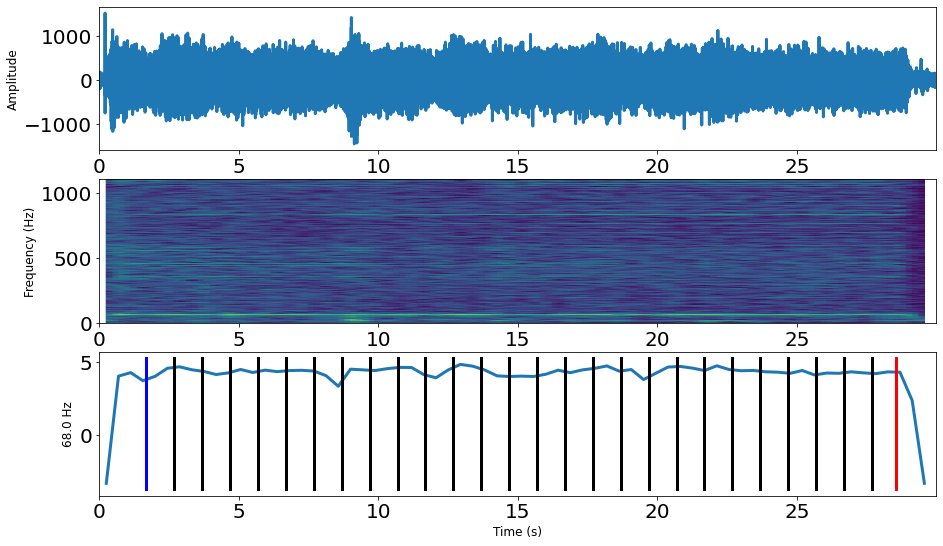

In [115]:
# Settings
down_sample_rate = get_parameter('down_sample_rate')
#down_sample_rate = 1
raw_data_dir = get_parameter('raw_data_path') + '/recordings_09_20' + sep
mic_id = 'mic_1'
rpm = '4k'
batch_id = 'n'
machine_id = '17'
tag = 'j'
template = 'recording_' + batch_id + machine_id + '_' + rpm + '_' + tag + '_' + mic_id

# Read the example file
files = listdir(raw_data_dir)
file = [f for f in files if (template in f) & (f[-4:] == '.wav')][0]
samplerate, signal = wavfile.read(raw_data_dir+file)

# Get the spectrogram and find the RPM frequency
n_per_segment = int(samplerate/down_sample_rate/2)
s_freq, s_time, spec = spectrogram(signal[::down_sample_rate], samplerate/down_sample_rate, nperseg=n_per_segment)
spec_log = np.log10(spec)
max_amp_along_freq = np.max(spec_log[:, :], axis=1)
max_freq_idx = np.argmax(max_amp_along_freq)

# Get onset and offset times
spec_log[max_freq_idx, 0] = spec_log.min() # ensure we start at the first time point even if the machine is running
spec_log[max_freq_idx, -1] = spec_log.min() # ensure we drop latest at the last time point
changes = np.hstack([0, np.diff((spec_log[max_freq_idx, :] > 0.25*spec_log[max_freq_idx, :].max())*1)])
onset_time = s_time[np.where(changes==1)[0][0]] + 1
offset_time = s_time[np.where(changes==-1)[0][-1]] - 1

# Plot the signal, the spectrogram, and the onset and offset times from the RPM frequency
time = np.arange(signal.size) / samplerate
fig, ax = plt.subplots(3, 1, figsize=[15, 9])
ax[0].plot(time[::down_sample_rate], signal[::down_sample_rate])
ax[0].set_ylabel('Amplitude');
ax[0].set_xlim([0, time[-1]])


colormesh = ax[1].pcolormesh(s_time, s_freq, spec_log, shading='gouraud')
ax[1].set_ylabel('Frequency (Hz)');
colormesh.set_clim([0, spec_log.max()])
ax[1].set_xlim([0, time[-1]])
#ax[1].set_ylim([0, 3000])


ax[2].plot(s_time, spec_log[max_freq_idx, :])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('{:1.1f} Hz'.format(s_freq[max_freq_idx]));
y_lim = ax[2].get_ylim()
ax[2].plot(np.array([1, 1])*onset_time,  y_lim, 'b-')
ax[2].plot(np.array([1, 1])*offset_time,  y_lim, 'r-');
segment_borders = np.arange(onset_time, offset_time, 1.) 
for onset_tmp in segment_borders[1:]:
    ax[2].plot(np.array([1, 1])*onset_tmp,  y_lim, 'k-');
ax[2].set_xlim([0, time[-1]]);

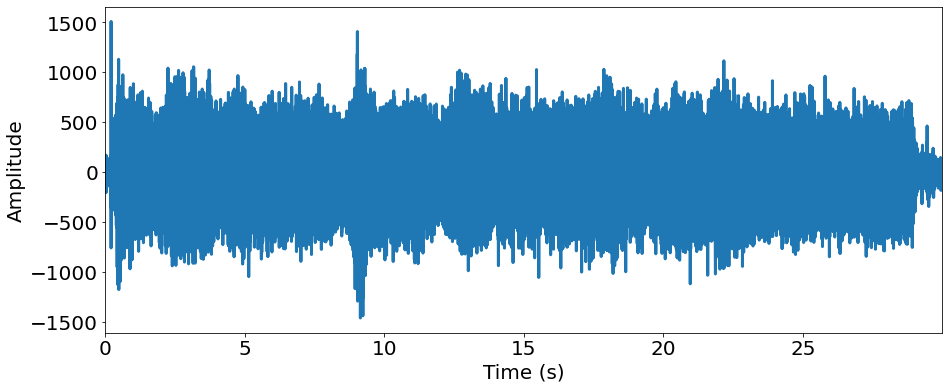

In [163]:

fig, ax = plt.subplots(1, 1, figsize=[15, 6])
time = np.arange(signal.size) / samplerate
ax.plot(time[::down_sample_rate], signal[::down_sample_rate])
ax.set_ylabel('Amplitude', fontsize=20);
ax.set_xlim([0, time[-1]])
ax.set_xlabel('Time (s)', fontsize=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
fig.savefig('Figure panels' + os.sep + 'signal_Time_Domain'+'.png', dpi=300) 

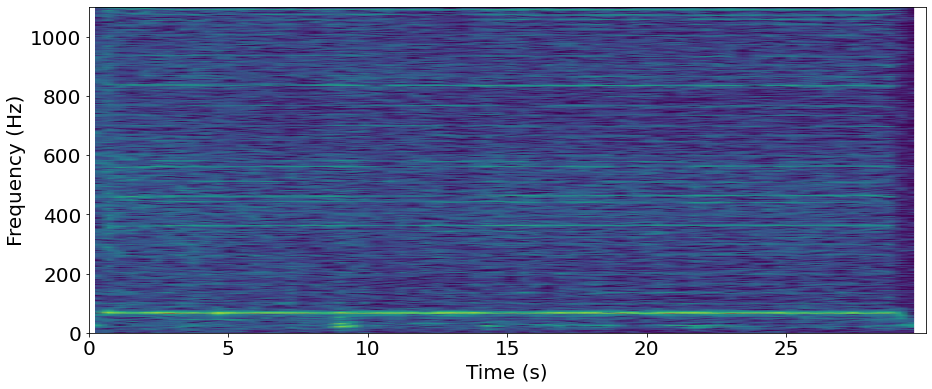

In [78]:
fig, ax = plt.subplots(1, 1, figsize=[15, 6])
colormesh = ax.pcolormesh(s_time, s_freq, spec_log, shading='gouraud')
ax.set_ylabel('Frequency (Hz)', fontsize=20);
colormesh.set_clim([0, spec_log.max()])
ax.set_xlim([0, time[-1]])
#ax[1].set_ylim([0, 3000])
ax.set_xlabel('Time (s)', fontsize=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
fig.savefig('Figure panels' + os.sep + 'signal_Spectrogram'+'.png', dpi=300) 

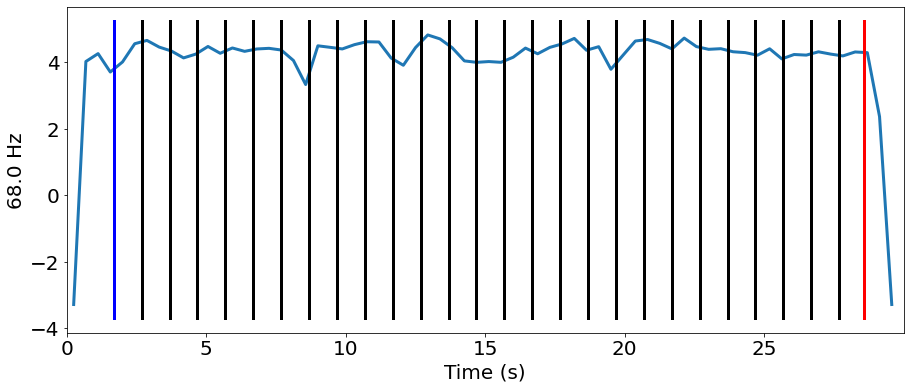

In [79]:
fig, ax = plt.subplots(1, 1, figsize=[15, 6])
ax.plot(s_time, spec_log[max_freq_idx, :])
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('{:1.1f} Hz'.format(s_freq[max_freq_idx]), fontsize=20);
y_lim = ax.get_ylim()
ax.plot(np.array([1, 1])*onset_time,  y_lim, 'b-')
ax.plot(np.array([1, 1])*offset_time,  y_lim, 'r-');
segment_borders = np.arange(onset_time, offset_time, 1.) 
for onset_tmp in segment_borders[1:]:
    ax.plot(np.array([1, 1])*onset_tmp,  y_lim, 'k-');
ax.set_xlim([0, time[-1]]);
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
fig.savefig('Figure panels' + os.sep +'signal_Frequency_Domain'+'.png', dpi=300) 


### Extract the spectra
Next we divide the full signal into non-overlapping segments and compute the spectra for each segment separately.

In [7]:
segment_duration = get_parameter('segment_duration')
segment_borders = np.arange(onset_time, offset_time, segment_duration)
batch_names = {'o' : 'old', 'n' : 'new'}

rpm_data = []
machine_data = []
spectral_data = []
for i in range(segment_borders.size-1):
#for i in [9]:
    
    onset_idx = np.int64(np.round(segment_borders[i]*samplerate))
    offset_idx = np.int64(np.round(segment_borders[i+1]*samplerate))
    spectra, real_rpm = data_extraction.compute_spectra_and_real_rpm(signal, samplerate, onset_idx, offset_idx)
    rpm = int(np.round(real_rpm/1e3)*1e3)
    
    machine_data.append( (file, batch_names[batch_id], int(machine_id), tag, mic_id, i, rpm, onset_idx, offset_idx) )
    spectral_data.append(spectra)
    rpm_data.append(real_rpm)

# Store all extracted data to a data frame 
machine_data_colums = ['File path', 
                       'Batch',
                       'Machine ID', 
                       'Tag', 
                       'Mic ID',
                       'Segment ID', 
                       'RPM', 
                       'Onset idx', 
                       'Offset idx']
df = pd.DataFrame(machine_data, columns=machine_data_colums)
# Add the real rpm values
df['Real RPM'] = rpm_data
# Add spectras
delta_freq = get_parameter('frequency_resolution')
cutoff_freq = get_parameter('cutoff_frequency')
spectra_columns = [str(i) for i in np.round(np.arange(0, cutoff_freq, delta_freq))]
df_spectra = pd.DataFrame(np.array(spectral_data), columns=spectra_columns)
df = pd.concat([df, df_spectra], axis=1)
df.head()

,File path,Batch,Machine ID,Tag,Mic ID,Segment ID,RPM,Onset idx,Offset idx,Real RPM,...,5900,5910,5920,5930,5940,5950,5960,5970,5980,5990
0,recording_n17_4k_j_mic_1_20210920T105949z.wav,new,17,j,mic_1,0,4000,74420,118520,4140.0,...,0.000017,0.000015,0.000019,0.000014,0.000016,0.000016,0.000024,0.000031,0.000020,0.000015
1,recording_n17_4k_j_mic_1_20210920T105949z.wav,new,17,j,mic_1,1,4000,118520,162620,4080.0,...,0.000027,0.000024,0.000018,0.000018,0.000022,0.000024,0.000015,0.000014,0.000016,0.000013
2,recording_n17_4k_j_mic_1_20210920T105949z.wav,new,17,j,mic_1,2,4000,162620,206720,4080.0,...,0.000027,0.000024,0.000017,0.000021,0.000024,0.000018,0.000020,0.000021,0.000020,0.000024
3,recording_n17_4k_j_mic_1_20210920T105949z.wav,new,17,j,mic_1,3,4000,206720,250820,4140.0,...,0.000008,0.000010,0.000023,0.000015,0.000010,0.000014,0.000014,0.000014,0.000016,0.000017
4,recording_n17_4k_j_mic_1_20210920T105949z.wav,new,17,j,mic_1,4,4000,250820,294920,4140.0,...,0.000013,0.000018,0.000016,0.000012,0.000012,0.000014,0.000015,0.000014,0.000021,0.000017


### Plot all spectras

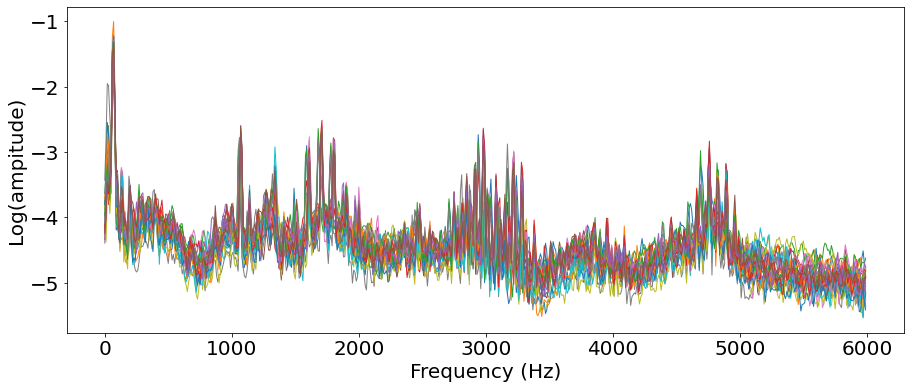

In [200]:
fig, ax = plt.subplots(1, 1, figsize=[15, 6])
spectra_columns_int = [i for i in np.round(np.arange(0, cutoff_freq, delta_freq))]
ax.plot(spectra_columns_int, np.log10(np.array(spectral_data)[:, :].T), lw=1);
ax.set_xlabel('Frequency (Hz)',fontsize=20)
ax.set_ylabel('Log(ampitude)',fontsize=20);
#plt.xlim([62, 2000])
fig.savefig('Figure panels' + os.sep +'spectrogram'+'.png', dpi=300) 

In [9]:
4000/60 * 25

1666.6666666666667

In [ ]:
%reset

In [ ]:
#%%writefile ../extract_spectral_data.py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import sep
from scipy.io import wavfile
from scipy.signal import spectrogram

import sys
sys.path.append('../')
from Code.project_configuration import get_parameter, set_up_project, get_machine_info
import Code.data_extraction as data_extraction

# Get paths and create directories if needed
set_up_project()
raw_data_dir = get_parameter('raw_data_path')
spectral_data_dir = get_parameter('spectral_data_dir')

dir_content = listdir(raw_data_dir)
raw_data_subdirs = [s for s in dir_content if 'recordings' in s]

# Parameters
segment_duration = get_parameter('segment_duration')
down_sample_rate = get_parameter('down_sample_rate')

rpm_data = []
machine_data = []
spectral_data = []
for raw_data_subdir in raw_data_subdirs:
    
    raw_data_dir_tmp = raw_data_dir + sep + raw_data_subdir
    files = sorted(listdir(raw_data_dir_tmp))
    for file in files:
        if file.endswith('.wav'):
            print(file)

            # extract meta data from the file name
            parts = file.split('mic')
            initial_parts = parts[0].split('_', 1)[1].split('_')
            machine_info = get_machine_info(initial_parts[0])
            intended_rpm = int(initial_parts[1][:-1]) * 1000
            tag = initial_parts[2]
            mic_id = int(parts[1][1])

            samplerate, signal = wavfile.read(raw_data_dir_tmp + sep + file)

            # Get a spectrogram and find the RPM frequency
            n_per_segment = int(samplerate/down_sample_rate/2)  # 500 ms windows
            s_freq, s_time, spec = spectrogram(signal[::down_sample_rate], samplerate/down_sample_rate, nperseg=n_per_segment)
            spec_log = np.log10(spec)
            max_amp_along_freq = np.max(spec_log, axis=1)
            max_freq_idx = np.argmax(max_amp_along_freq)
            # Get the onset and offset time based on the onset and offset time of the RPM frequency (highest amplitude)
            spec_log[max_freq_idx, 0] = spec_log.min() # ensure we start at the first time point even if the machine is running
            spec_log[max_freq_idx, -1] = spec_log.min() # ensure we drop latest at the last time point
            changes = np.hstack([0, np.diff((spec_log[max_freq_idx, :] > 0.5*spec_log[max_freq_idx, :].max())*1)])
            onset_time = s_time[np.where(changes==1)[0][0]] + 1
            offset_time = s_time[np.where(changes==-1)[0][-1]] - 1

            # Divide the recording into non-overlapping segments of equal duration
            segment_borders = np.arange(onset_time, offset_time, segment_duration)
            # Loop over each segment and extract the spectra
            for i in range(segment_borders.size-1):
                onset_idx = np.int64(np.round(segment_borders[i]*samplerate))
                offset_idx = np.int64(np.round(segment_borders[i+1]*samplerate))
                spectra, real_rpm = data_extraction.compute_spectra_and_real_rpm(signal, samplerate, onset_idx, offset_idx)

                found_rpm = int(np.round(real_rpm/1e3)*1e3)
                if intended_rpm == found_rpm:
                    machine_data.append( (file, machine_info[0], machine_info[1], machine_info[2], tag, mic_id, i, intended_rpm, onset_idx, offset_idx) )
                    spectral_data.append(spectra)
                    rpm_data.append(real_rpm)

# Store all extracted data to a data frame 
machine_data_colums = ['File path', 
                       'Machine ID',
                       'Status',
                       'Fault code',
                       'Tag', 
                       'Mic ID',
                       'Segment ID', 
                       'RPM', 
                       'Onset idx', 
                       'Offset idx']
df = pd.DataFrame(machine_data, columns=machine_data_colums)
# Add the real rpm values
df['Real RPM'] = rpm_data
# Add spectras
delta_freq = get_parameter('frequency_resolution')
cutoff_freq = get_parameter('cutoff_frequency')
spectra_columns = [str(i) for i in np.round(np.arange(0, cutoff_freq, delta_freq))]
df_spectra = pd.DataFrame(np.array(spectral_data), columns=spectra_columns)
df = pd.concat([df, df_spectra], axis=1)

# Save to file
delta_freq = get_parameter('frequency_resolution')
cutoff_freq = get_parameter('cutoff_frequency')
df.to_csv(spectral_data_dir + 'spectral_data_new_' + str(delta_freq) + '_' + str(cutoff_freq) + '.csv')
df.head()

In [29]:
import numpy as np
from os.path import sep
import pandas as pd
import sys
sys.path.append('../')
from Code1.project_configuration import get_parameter


file_name= 'spectral_data_new_10_6000.csv' 
spectral_data_dir = get_parameter('spectral_data_dir')

df = pd.read_csv(spectral_data_dir+sep+file_name, index_col=0)

In [30]:
df

,File path,Machine ID,Status,Fault code,Tag,Mic ID,Segment ID,RPM,Onset idx,Offset idx,...,5900,5910,5920,5930,5940,5950,5960,5970,5980,5990
0,recording_n10_10k_j2_mic_1_20210920T115116z.wav,20,OK,0,j2,1,0,10000,113020,157120,...,0.000026,0.000015,0.000009,0.000015,1.513223e-05,0.000018,0.000012,1.140781e-05,0.000017,0.000012
1,recording_n10_10k_j2_mic_1_20210920T115116z.wav,20,OK,0,j2,1,1,10000,157120,201220,...,0.000028,0.000026,0.000024,0.000011,1.249639e-05,0.000013,0.000013,1.514041e-05,0.000018,0.000018
2,recording_n10_10k_j2_mic_1_20210920T115116z.wav,20,OK,0,j2,1,2,10000,201220,245320,...,0.000011,0.000024,0.000027,0.000014,1.115866e-05,0.000005,0.000009,1.210647e-05,0.000012,0.000019
3,recording_n10_10k_j2_mic_1_20210920T115116z.wav,20,OK,0,j2,1,3,10000,245320,289420,...,0.000019,0.000019,0.000015,0.000011,5.844353e-06,0.000004,0.000007,2.195862e-05,0.000026,0.000020
4,recording_n10_10k_j2_mic_1_20210920T115116z.wav,20,OK,0,j2,1,4,10000,289420,333520,...,0.000008,0.000015,0.000019,0.000011,6.509629e-06,0.000008,0.000010,7.708593e-06,0.000005,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6020,recording_o9_4k_j_mic_2_20210920T102730z.wav,9,Faulty,3,j,2,21,4000,1039120,1083220,...,0.000002,0.000002,0.000003,0.000003,2.891686e-06,0.000002,0.000002,1.231828e-06,0.000001,0.000001
6021,recording_o9_4k_j_mic_2_20210920T102730z.wav,9,Faulty,3,j,2,22,4000,1083220,1127320,...,0.000002,0.000002,0.000004,0.000002,7.709912e-07,0.000002,0.000003,9.728566e-07,0.000002,0.000002
6022,recording_o9_4k_j_mic_2_20210920T102730z.wav,9,Faulty,3,j,2,23,4000,1127320,1171420,...,0.000002,0.000002,0.000003,0.000002,1.677131e-06,0.000002,0.000002,1.041816e-06,0.000002,0.000002
6023,recording_o9_4k_j_mic_2_20210920T102730z.wav,9,Faulty,3,j,2,24,4000,1171420,1215520,...,0.000001,0.000001,0.000002,0.000001,8.428757e-07,0.000001,0.000002,1.769172e-06,0.000003,0.000003
